In [253]:
!pip install -U imbalanced-learn
!pip install imblearn

# Sentiment Classification - Kaggle

This notebook is dedicated to building a sentiment classification model and submit to this kaggle challenge: https://www.kaggle.com/competitions/comp3020-f23-assignment-3-sentiment-part2/overview

In the preprocessing phase, the NLTK libary is used. The code begins by downloading ’wordnet’ from NLTK, which is a large lexical database for the English language that NLTK uses for tasks like lemma- tization. It then imports PorterStemmer and WordNetLemmatizer from NLTK, which are classes used for stemming and lemmatization, respectively. The subtasks in this step are iterated over each piece of text in the train[’text’] dataset, applying multiple preprocessing steps to each text entry:
- HTML Tag Removal: The text is cleaned of HTML tags using a regular expression that matches and removes them.
- Contraction Expansion: Contractions (like “can’t” or “won’t”) are expanded to their full form (like “cannot” or “will not”) using the contractions.fix function.
- Special Characters and Digit Removal: All special characters (non-alphanumeric) are removed from the text, leaving only letters, numbers, and whitespace. All digits are removed from the text, ensuring that only letters remain.
- URL and Email Address Removal: URLs and email addresses are stripped out of the text using regular expressions.
- Lowercasing, Stopword Removal, Stemming, and Lemmatization: The text is converted to lowercase. Any stopwords (commonly used words that don’t contribute significant meaning, like “and”, “the”, “is”) are removed. Words are first stemmed using PorterStemmer, which reduces words to their root form by removing common word endings. For example, “running” becomes “run”. The stemmed words are then lemmatized using WordNetLemmatizer, which further reduces words to their base or dictionary form. For example, “better” becomes “good”.
- Final Processing: Words with a length of less than 3 characters are removed. The processed words are joined back into a single string with spaces and added to the processed_text list.

The preprocesses steps are to make sure that the data is clean and free of any noise. Then, I also look through the data to see if the classes are balanced or not. Since we have imbalanced dataset, in the next steps, I would implement balanced class weight and resampling method such as SMOTE for each case.

After processing, I tried the following embedder: n-gram, TF-IDF, Count Vectorizer and Hashing Vec- torizer, on Logistic Regression and MLP Classifier with logistic activation in sklearn. The Decision Tree and K-NN are skipped due to its long time taken to process the model. K-NN is also not suitable for the sentiment classification task, due to the sparse nature of vectorized text. The models are also tested with both preprocessed and unprocessed data to see if there is any significant result. For each vectorizer, both preprocessed and not-preprocessed data are utilized, embedded then fit into the model.

After different trials and errors, the F1 for the baseline model is around 0.77-0.80. The best classifier I could found is by using n-gram embedder and logistic regression model, with random state = 149, balanced class weight. Due to the nature of ML, the result may not be deterministic over different versions or packages.

In [254]:
!pip install contractions
!pip install tqdm

In [255]:
import contractions
from tqdm import tqdm

In [256]:
import numpy as np
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,text,labels
0,"Unfortunately, the frustration of being Dr. Go...",0
1,I don't know what Dr. Goldberg was like before...,0
2,I'm writing this review to give you a heads up...,0
3,Wing sauce is like water. Pretty much a lot of...,0
4,Owning a driving range inside the city limits ...,0


In [257]:
test = pd.read_csv("test.csv")
test.head()

,id,input
0,0,I really don't understand the hype of this pla...
1,1,In today's economy where most businesses try t...
2,2,i am a sucker for this place. its not that is ...
3,3,I have been coming here for years! The prices...
4,4,This might be a good way to kill time if you'r...


In [258]:
train['labels'].value_counts()

0    7000
1    3000
Name: labels, dtype: int64

# Data Preprocessing

In [259]:
import regex as re
print(train['text'][1000])
re.sub('(<[\w\s]*/?>)',"",train['text'][1000])
re.sub('(<[\w\s]*/?>)',"",test['input'][1000])

I had the famous Pitts-Burger and it was disgusting! The only reason I'm giving it two stars is because of the bread. The bread is super soft and tasty but the meat was gross and the cole slaw was bitter. I don't see what the hype is all about!


'Love it here! Great beds...always see amazing results! Staff is VERY knowledgeable and friendly! Good prices and a variety of lotions to chose from at any price point! Have been coming here for months and will continue! So happy to find such a great place so close home!!!'

In [260]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/haphuongthao/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Remove stopwords

In [261]:
nltk.download('stopwords')
from nltk.corpus import stopwords
#donwloadin the stopwords of english language
stopwords=stopwords.words('english')
#Removing stopwords 'no','nor' and 'not'
print('not' in stopwords)
stopwords.remove('no')
stopwords.remove('nor')
stopwords.remove('not')
print('not' in stopwords)

True
False


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haphuongthao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [262]:
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

processed_text=[]
for i in tqdm(train['text']):
    #Regular expression that removes all the html tags pressent in the reviews
    i=re.sub('(<[\w\s]*/?>)',"",i)
    #Expanding all the contractions present in the review to is respective actual form
    i=contractions.fix(i)
    #Removing all the special charactesrs from the review text
    i=re.sub('[^a-zA-Z0-9\s]+',"",i)
    #Removing all the digits present in the review text
    i=re.sub('\d+',"",i)
    #Removing number
    i=re.sub(r'\d+', '', i)
    # Remove URLs
    i = re.sub(r'http\S+|www\S+|https\S+', '', i)
    # Remove email addresses
    i = re.sub('\S*@\S*\s?', '', i)
    #Making all the review text to be of lower case as well as remvoing the stopwords and words of length less than 3
    processed_text.append(" ".join([lemmatizer.lemmatize(stemmer.stem(j.lower())) for j in i.split() if j not in stopwords and len(j) >= 3]))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/haphuongthao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|████████████████████████████████████| 10000/10000 [00:26<00:00, 376.28it/s]


## Lemmatize words

In [263]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
processed_test=[]
for i in tqdm(test['input']):
    #Regular expression that removes all the html tags pressent in the reviews
    i=re.sub('(<[\w\s]*/?>)',"",i)
    #Expanding all the contractions present in the review to is respective actual form
    i=contractions.fix(i)
    #Removing all the special charactesrs from the review text
    i=re.sub('[^a-zA-Z0-9\s]+',"",i)
    #Removing all the digits present in the review text
    i=re.sub('\d+',"",i)
    #Removing number
    i=re.sub(r'\d+', '', i)
    # Remove URLs
    i = re.sub(r'http\S+|www\S+|https\S+', '', i)
    # Remove email addresses
    i = re.sub('\S*@\S*\s?', '', i)
    #Making all the review text to be of lower case as well as remvoing the stopwords and words of length less than 3
    processed_test.append(" ".join([lemmatizer.lemmatize(stemmer.stem(j.lower())) for j in i.split() if j not in stopwords and len(j) >= 3]))

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 424.51it/s]


In [264]:
processed_train=pd.DataFrame({'text':processed_text,'labels':list(train['labels'])})
processed_test=pd.DataFrame({'id':test['id'],'text':processed_test})

In [265]:
processed_test.head()

,id,text
0,0,realli not understand hype place honest person...
1,1,today economi busi tri provid least charg feel...
2,2,sucker place not soooo fantast phoenixscottsda...
3,3,come year the price great owner gem the rest s...
4,4,thi might good way kill time near airport food...


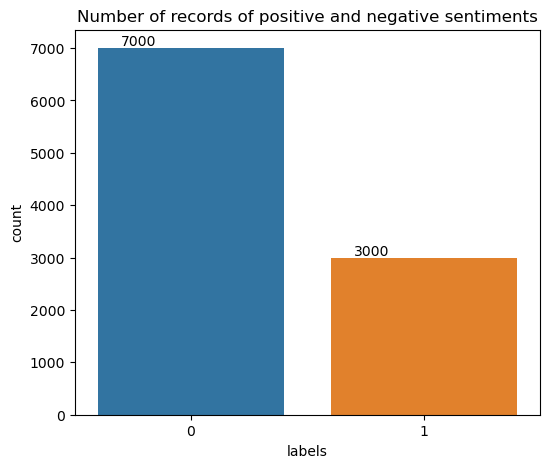

In [266]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
plt.figure(figsize=(6,5))
plt.title("Number of records of positive and negative sentiments")
plot = sn.countplot(x = 'labels', data=processed_train)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+0.1 ,p.get_height()+50))

# Text vectorizer

This notebook is going to attempt different text vectorizers, such as TF-IDF, n-gram, and hashing and evaluating the model performance by observing the F1 score. I am going to compare the performance of the model while using these text vectorizers on both pre-processed and unprocessed data.

## TF-IDF

In [377]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)
tfidf_x_train = tfidf.fit_transform(processed_train['text'])

In [390]:
from sklearn.model_selection import train_test_split
x_train_tf,x_val_tf,y_train_tf,y_val_tf=train_test_split(tfidf_x_train,processed_train['labels'],test_size=0.2, random_state=149)

In [391]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, solver='saga')
clf.fit(x_train_tf, y_train_tf)
predictions = clf.predict(x_val_tf)

# Calculate f1
accuracy = f1_score(y_val_tf, predictions)
print("Val f1 without resample:", accuracy)

Val f1 without resample: 0.8470149253731343


In [392]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, class_weight='balanced', solver='saga')
clf.fit(x_train_tf, y_train_tf)
predictions = clf.predict(x_val_tf)

# Calculate accuracy
accuracy = f1_score(y_val_tf, predictions)
print("Val f1 without resample:", accuracy)

Val f1 without resample: 0.8618693134822166


In [246]:
# # Vectorize the test data
# test_data_vectorized = tfidf.transform(processed_test['text'])

# # Make predictions using the trained model
# test_predictions = clf.predict(test_data_vectorized)

# # Add predictions to the test_data DataFrame
# processed_test['label'] = test_predictions

# processed_test.drop(columns=['text'], inplace=True)

# processed_test.to_csv('Thao tfidf.csv', index=False)

In [247]:
processed_test.head()

,id,text
0,0,realli not understand hype place honest person...
1,1,today economi busi tri provid least charg feel...
2,2,sucker place not soooo fantast phoenixscottsda...
3,3,come year the price great owner gem the rest s...
4,4,thi might good way kill time near airport food...


In [248]:
processed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   text    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, class_weight='balanced', solver='saga')
clf.fit(x_train_tf, y_train_tf)
predictions = clf.predict(x_val_tf)

# Calculate accuracy
accuracy = f1_score(y_val_tf, predictions)
print("Val f1 without resample:", accuracy)

Val f1 without resample: 0.8463356973995271


In [250]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
print('Original dataset shape %s' % Counter(y_train_tf))
sm = SMOTE(random_state=42)
x_train_tf_res, y_train_tf_res = sm.fit_resample(x_train_tf, y_train_tf)
print('Resampled dataset shape %s' % Counter(y_train_tf_res))

Original dataset shape Counter({0: 5608, 1: 2392})
Resampled dataset shape Counter({1: 5608, 0: 5608})


In [251]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42)
clf.fit(x_train_tf_res, y_train_tf_res)
predictions = clf.predict(x_val_tf)

# Calculate f1
accuracy = f1_score(y_val_tf, predictions)
print("Val f1 with resample:", accuracy)

Val f1 with resample: 0.8435054773082942


In [252]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(x_train_tf_res, y_train_tf_res)
predictions = clf.predict(x_val_tf)

# Calculate f1
accuracy = f1_score(y_val_tf, predictions)
print("Val f1 with resample:", accuracy)

Val f1 with resample: 0.8435054773082942


### Without preprocessing

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
tf = TfidfVectorizer()
tf_x_train = tf.fit_transform(train['text'])

In [127]:
from sklearn.model_selection import train_test_split
x_train_tf,x_val_tf,y_train_tf,y_val_tf=train_test_split(tf_x_train,train['labels'],test_size=0.2, random_state=42)

In [128]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42)

# Train the Perceptron classifier
clf.fit(x_train_tf, y_train_tf)

# Predict using the trained classifier
predictions = clf.predict(x_val_tf)

# Calculate f1 on the test data
accuracy = f1_score(y_val_tf, predictions)
print("Val f1:", accuracy)

Val f1: 0.8164435946462715


['tf_perceptron_no_preprocessing.pkl']

## n-gram

In [400]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(ngram_range=(1, 3),min_df=5, max_df=0.9, strip_accents='unicode')
vectorized_x_train=vectorizer.fit_transform(processed_train['text'])

In [401]:
from sklearn.model_selection import train_test_split
x_train_cv,x_val_cv,y_train_cv,y_val_cv=train_test_split(vectorized_x_train,processed_train['labels'],test_size=0.2, random_state=149)

In [402]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, solver='saga')
clf.fit(x_train_cv, y_train_cv)
predictions = clf.predict(x_val_cv)

# Calculate f1
accuracy = f1_score(y_val_cv, predictions)
print("Val f1 without resample:", accuracy)

Val f1 without resample: 0.8633594429939078


/Users/haphuongthao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [403]:
# best model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, class_weight="balanced", solver='saga')
clf.fit(x_train_cv, y_train_cv)
predictions = clf.predict(x_val_cv)

# Calculate accuracy
accuracy = f1_score(y_val_cv, predictions)
print("Val f1 without resample:", accuracy)

Val f1 without resample: 0.867109634551495


/Users/haphuongthao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [404]:
# Vectorize the test data
test_data_vectorized = vectorizer.transform(processed_test['text'])

# Make predictions using the trained model
test_predictions = clf.predict(test_data_vectorized)

# Add predictions to the test_data DataFrame
processed_test['label'] = test_predictions

processed_test.drop(columns=['text'], inplace=True)

processed_test.to_csv('Thao ngrams.csv', index=False)

In [396]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
print('Original dataset shape %s' % Counter(y_train_cv))
sm = SMOTE(random_state=42)
x_train_cv_res, y_train_cv_res = sm.fit_resample(x_train_cv, y_train_cv)
print('Resampled dataset shape %s' % Counter(y_train_cv_res))

Original dataset shape Counter({0: 5594, 1: 2406})
Resampled dataset shape Counter({1: 5594, 0: 5594})


In [397]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42,solver='saga')
clf.fit(x_train_cv_res, y_train_cv_res)
predictions = clf.predict(x_val_cv)

# Calculate f1
accuracy = f1_score(y_val_cv, predictions)
print("Val f1 with resample:", accuracy)

Val f1 with resample: 0.8381742738589212


/Users/haphuongthao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [398]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, solver='saga')
clf.fit(x_train_cv_res, y_train_cv_res)
predictions = clf.predict(x_val_cv)

# Calculate accuracy
accuracy = f1_score(y_val_cv, predictions)
print("Val f1 with resample:", accuracy)

Val f1 with resample: 0.8381742738589212


/Users/haphuongthao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Without preprocessing

In [163]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
cv = CountVectorizer()
cv_x_train = cv.fit_transform(train['text'])

In [164]:
from sklearn.model_selection import train_test_split
x_train_cv,x_val_cv,y_train_cv,y_val_cv=train_test_split(cv_x_train,train['labels'],test_size=0.2, random_state=42)

In [165]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=42, solver='saga')

# Train the classifier
clf.fit(x_train_cv, y_train_cv)

# Predict using the trained classifier
predictions = clf.predict(x_val_cv)

# Calculate f1 on the test data
accuracy = f1_score(y_val_cv, predictions)
print("Test f1:", accuracy)

Test f1: 0.8292682926829269


/Users/haphuongthao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


['tfidf_no_preprocessing.pkl']

## Hashing Vectorizer

In [405]:
from sklearn.feature_extraction.text import HashingVectorizer
hashing_vectorizer = HashingVectorizer(ngram_range=(1, 3), strip_accents='unicode')
hashing_x_train = hashing_vectorizer.fit_transform(processed_train['text'])

In [406]:
from sklearn.model_selection import train_test_split
x_train_h,x_val_h,y_train_h,y_val_h=train_test_split(hashing_x_train,processed_train['labels'],test_size=0.2, random_state=149)

In [407]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, solver='saga')
clf.fit(x_train_h, y_train_h)
predictions = clf.predict(x_val_h)

# Calculate f1
accuracy = f1_score(y_val_h, predictions)
print("Val accuracy without resample:", accuracy)

Val accuracy without resample: 0.7678571428571428


In [408]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, class_weight = 'balanced', solver='saga')
clf.fit(x_train_h, y_train_h)
predictions = clf.predict(x_val_h)

# Calculate f1
accuracy = f1_score(y_val_h, predictions)
print("Val f1 without resample:", accuracy)

Val f1 without resample: 0.8175061932287365


In [409]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
print('Original dataset shape %s' % Counter(y_train_h))
sm = SMOTE(random_state=42)
x_train_h_res, y_train_h_res = sm.fit_resample(x_train_h, y_train_h)
print('Resampled dataset shape %s' % Counter(y_train_h_res))

Original dataset shape Counter({0: 5594, 1: 2406})
Resampled dataset shape Counter({1: 5594, 0: 5594})


In [410]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=42, solver='saga')
clf.fit(x_train_h_res, y_train_h_res)
predictions = clf.predict(x_val_h)

# Calculate f1
accuracy = f1_score(y_val_h, predictions)
print("Val f1 with resample and no weight balance:", accuracy)

Val f1 with resample and no weight balance: 0.8218954248366014
